## INTRODUZIONE
Il dataset contiene informazioni sull’interesse di clienti di una compagnia di assicurazioni per l’acquisto di
polizze auto.
Inizialmente le colonne che compongono il dataset sono 12, di cui una, l'ultima è quella che identifica la classe di
appartenenza delle istanze. Le features sono informazioni di base delle persone prese in esame, quali età, sesso, ecc,
oltrechè informazioni sul veicolo e sulla situazione assicurativa.
Per prima cosa vengono importate le 3 librerie seguenti che torneranno utili nel corso dell'analisi, infatti pandas è
uno strumento indispensabile per la gestione e la manipolazione dei dati mentre seaborn e matplotlib sono utili per
le rappresentazioni grafiche di dati e risultati

In [2]:
#IMPORTAZIONE DELLE LIBRERIE
import pandas as pd #PER STRUTTURE DATI E MANIPOLAZIONE (DF/SERIES)
import seaborn as sns #PER PLOT
import matplotlib.pyplot as plt #PER PLOT

Per prendere confidenza ed avere una prima idea di come si compone il dataset si usano le funzioni head() e
describe(). Alcune cose che possiamo notare sono la maggioranza dei soggetti di sesso maschile, che le auto che sono
state coinvolte in un sinistro sono più delle auto che non sono mai state coinvolte in incidenti e che la media delle
auto ha tra 1 e 2 anni.
Viene anche effettuato il primo passaggio di pre-processing rimuovendo la colonna `id` che non serve nè per l'analisi
nè per la classificazione

In [3]:
#CREAZIONE DEL DATASET E VISUALIZZAZIONE DI DIMENSIONI
#VISUALIZZAZIONI TIPI DI DATO DELLE COLONNE
df = pd.read_csv('insurance.csv')
df.head()
# Alcune feature necessitano di essere manipolate prima di essere utilizzate
# Ad esempio la colonna id viene tolta in quanto irrilevante ai fini dell'analisi

df.describe()

#Mostro i valori unici presenti in ogni colonna
df = df.drop(columns = 'id')

for column in df.columns:
    print(f"{column}: ")
    print("")
    print(df[column].unique())
    print("")

df.describe(include = 'O')

Gender: 

['Male' 'Female']

Age: 

[44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]

Driving_License: 

[1 0]

Region_Code: 

[28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]

Previously_Insured: 

[0 1]

Vehicle_Age: 

['> 2 Years' '1-2 Year' '< 1 Year']

Vehicle_Damage: 

['Yes' 'No']

Annual_Premium: 

[ 40454.  33536.  38294. ...  20706. 101664.  69845.]

Policy_Sales_Channel: 

[ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  15.
 154.  16.  52. 155.  11. 151. 125.  25.  61.   1.  86.  31. 150.  23.
  60.  21. 121.   3. 139.  12.  29.  55.   7.  47. 127. 153.  78. 158.
  89.  32.   8.  10. 120.  65.   4.  42.  83. 136.  24.  18.  56.  48.
 106.  54

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


##BOXPLOT

Per rappresentare graficamente la distribuzione dei valori delle 3 features numeriche
`Age`, `Annual_Premium` e `Vintage` e controllare la presenza di outliers si stampano i relativi boxplot. Mentre per il
primo ed il terzo non si notano anomalie, per il boxplot relativo ad `Annual_Premium` si nota che la maggioranza delle
persone paga cifre molto simili tra loro e abbastanza basse, mentre un numero non trascurabile di persone paga una
cifra molto più elevata per la propria assicurazione. Essendo queste istanze di numero elevato, non possiamo assumere
che siano effettivamente valori anomali ed inoltre eliminarli potrebbe portare i modelli a classificare male potenziali
clienti che hanno un valore alto in tale feature. Ancora, questi potenziali clienti potrebbero essere di particolare
interesse proprio in virtù del loro premio particolarmente alto


In [3]:
#BOXPLOT DI AGE, ANNUAL_PREMIUM E VINTAGE
plt.subplot(1, 3, 1)
plt.boxplot(df[['Age']], flierprops={'marker': 'o', 'markersize': 2})
plt.subplot(1, 3, 2)
plt.boxplot(df[['Annual_Premium']], flierprops={'markersize': 2})
plt.subplot(1, 3, 3)
plt.boxplot(df[['Vintage']], flierprops={'markersize': 2})
plt.show()


## PRE-PROCESSING

Per poter essere utilizzate efficientemente, alcune colonne hanno bisogno di essere manipolate. In particolare:

* La colonna `Gender`, viene trasformata nella colonna `Male`, che ammette valori binari `0` e `1` dove `1` rappresenta
il sesso maschile e `0` quello femminile.
* La colonna `Vehicle_Age` viene convertita da categorica ordinata a numerica. I valori utilizzati sono:
  + -1 per le auto immatricolate da meno di un anno
  + 0 per le auto immatricolate tra gli 1 e i 2 anni precedenti
  + 1 per le auto immatricolate da più di 2 anni
* La colonna `Vehicle_Damage` viene convertita da categorica nominale a factor. I valori utilizzati sono:
  + 0 per le auto che non sono mai state coinvolte in incidenti
  + 1 per le auto che sono state coinvolte in incidenti

In [3]:
# PRE-PROCESSING
# CONVERSIONE DI "GENDER" IN BINARIO (MALE)
# CONVERSIONE DI VEHICLE_AGE IN NUMERICO E VEHICLE_DAMAGE IN BINARIO
df = df.rename(columns={"Gender": "Male"})
cleanup_nums = {"Vehicle_Age": {"< 1 Year": -1, "1-2 Year": 0, "> 2 Years": 1},
                "Vehicle_Damage": {"Yes": 1, "No": 0},
                "Male": {"Male": 1, "Female": 0}} #DIZIONARIO CONTENENTE
                                                  #REGOLE DI CONVERSIONE
df = df.replace(cleanup_nums)

## MATRICE DI CORRELAZIONE E SBILANCIAMENTO

Nonostante il numero non elevato di features presenti nel dataset possiamo cercare la correlazione presente tra esse. Dalla correlation matrix si può notare che le
features `Vehicle_Age` e `Age` sono piuttosto correlate tra loro. Nonostante questo
ho deciso di mantenerle entrambe poichè il vantaggio dal punto di vista computazionale
è minimo, evitando cosi perdita di informazioni.
Uno degli aspetti più critici del dataset in analisi è lo sbilanciamento tra le classi,
come si evince dal seguente piechart. Infatti le percentuali evidenziano uno sbilanciamento di 88% a favore della
classe dei negativi contro il 12% della classe dei positivi

In [ ]:
#MATRICE DI CORRELAZIONE
import numpy as np #PER TRIANGOLIZZAZIONE MATRICE DI CORRELAZIONE
corMatrix = df[['Age', 'Vehicle_Age', 'Annual_Premium', 'Vintage']].corr()
Matrix = np.triu(corMatrix)
sns.heatmap(corMatrix, annot=True, square=True, mask = Matrix)
plt.show()

#GRAFICO A TORTA CHE DIMOSTRA LO SBILANCIAMENTO
freq = df['Response'].value_counts(normalize=True) * 100
plt.pie(freq, autopct='%.0f%%')
plt.legend(['0', '1'])
plt.show()


## SEPARAZIONE STRATIFICATA

Per addestrare e validare i modelli che verranno realizzati si divide il dataset originale nei due dataset di training
e testing nella classica proporzione percentuale di 70-30. Il criterio di separazione scelto è quello stratificato
perchè consente di mantenere la proporzione tra le istanze della classe di maggioranza e quella di minoranza
all'interno dei due dataset. E' stata fatta questa scelta perchè il dataset originale è molto sbilanciato, ed in
questo modo evitiamo di creare dei dataset ancora più sbilanciati

In [4]:
#SPLIT STRATIFICATO TEST/TRAIN
from sklearn import model_selection

y = df['Response']
x = df.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)

La seguente funzione viene creata sfruttando le funzioni appartenenti a sklearn e restituisce e stampa i valori di
accuracy, sensitivity, specificity prendendo in input la predizione generata da un modello e la relativa ground truth

In [ ]:
#FUNZIONE PER GENERAZIONE DI MATRICE DI CONFUSIONE E RESTITUZIONE DI PARAMETRI
#INTERESSANTI
def confusionMatrix (Prediction, Ground_Truth, verbose = False):
    from sklearn.metrics import confusion_matrix as cm
    CM = cm(Ground_Truth, Prediction)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    accuracy = (TP+TN)/(TP + FN + FP + TN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    if verbose:
        print("Accuracy:      %f\n" % accuracy)
        print("Sensitivity:   %f\n" % sensitivity)
        print("Specificity:   %f\n" % specificity)
    return accuracy, sensitivity, specificity

Al fine di rendere meno ripetitivo il codice viene creata una funzione che genera e testa un albero oltre che
restituirlo come risultato

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#FUNZIONE PER LA CREAZIONE E IL TESTING DI ALBERI
def tree_test(X_train, y_train, X_test, y_test, verbose = True):
    dtree = DecisionTreeClassifier(random_state=1)
    dtree = dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    confusionMatrix(pred, y_test, verbose)
    return dtree

La seguente funzione restituisce il false positive rate ed il true positive rate a partire da un modello ed un dataset
su cui testarlo. Questi valori tornano utili per la generazione della curva ROC


In [ ]:
#FUNZIONE PER SALVATAGGIO DI 'fpr' E 'tpr' A PARTIRE DA MODELLO
def f_t_pr(model, X_test, y_test):
    from sklearn.metrics import roc_curve
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return fpr, tpr

## ALBERO DI DECISIONE SU TESTING SBILANCIATO

Nonostante lo sbilanciamento si prova a generare un primo modello, in particolare viene generato un albero di
decisione. Per fare ciò ci si può avvalere del `DecisionTreeClassifier` di sklearn, che genera un albero implementando
l'algoritmo CART ed utilizzando quindi l'indice di Gini come criterio per lo splitting

In [ ]:
#CREZIONE DI DATASET SENZA VARIABILI CATEGORICHE (PER ALBERO)
X_train_num = X_train.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
X_test_num = X_test.drop(['Region_Code', 'Policy_Sales_Channel'], axis=1)
dtree = tree_test(X_train_num, y_train, X_test_num, y_test)

Si può notare che i risultati sono molto deludenti. Nonostante questo sia molto probabilmente dato dallo sbilanciamento
dei dati vogliamo assicurarci di non incorrere nel fenomeno dell'overfitting. Per fare ciò si osservano i valori di
accuracy, sensitivity e specificity forniti al variare dell'altezza dell'albero. Osservando i risultati riportati di
seguito si conferma quanto detto inizialmente, poichè le prestazioni non migliorano significativamente al variare
dell'altezza

In [ ]:
#VOGLIAMO VISUALIZZARE L'IMPATTO DELLA PROFONDITA' E DEL CRITERIO DI SPLIT
# SULLA QUALITA DELL'ALBERO (VERIFICARE RISCHIO OVERFITTING)
max = dtree.get_depth()
max_depth = []
acc_gini = []
acc_entropy = []
sens_gini = []
spec_gini = []
sens_entropy = []
spec_entropy = []
for i in range(1,max):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=1)
 dtree.fit(X_train_num, y_train)
 pred = dtree.predict(X_test_num)
 acc_gini.append(confusionMatrix(pred, y_test)[0])
 sens_gini.append(confusionMatrix(pred, y_test)[1])
 spec_gini.append(confusionMatrix(pred, y_test)[2])
 ####
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=1)
 dtree.fit(X_train_num, y_train)
 pred = dtree.predict(X_test_num)
 acc_entropy.append(confusionMatrix(pred, y_test)[0])
 sens_entropy.append(confusionMatrix(pred, y_test)[1])
 spec_entropy.append(confusionMatrix(pred, y_test)[2])
 ####
 max_depth.append(i)

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                  'sens_gini': pd.Series(sens_gini),
                  'spec_gini': pd.Series(spec_gini),
                  'acc_entropy':pd.Series(acc_entropy),
                  'sens_entropy':pd.Series(sens_entropy),
                  'spec_entropy':pd.Series(spec_entropy),
                  'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot('max_depth','sens_gini', data=d, label='gini')
plt.plot('max_depth','sens_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('sensitivity')
plt.legend()
plt.show()

plt.plot('max_depth','spec_gini', data=d, label='gini')
plt.plot('max_depth','spec_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('specificity')
plt.legend()
plt.show()

Alla luce delle prestazioni mostrate da questo primo modello è bene procedere ad un ribilanciamento delle classi.
Per fare ciò mi sono avvalso di due tecniche:
* Tecnica di sottocampionamento casuale che consiste nel rimuovere casualmente istanze della classe di maggioranza
 fino ad avere un bilanciamento di circa 50-50
* Sovracampionamento effettuato attraverso SMOTE, che genera istanze sintetiche della classe di minoranza sfruttando
un algoritmo di k-nearest neighbors (K = 5 nel mio caso)
* SMOTE + RANDOM UNDERSAMPLING come suggerito dal paper ufficiale di SMOTE


In [ ]:
#RIBILANCIAMENTO CON UNDERSAMPLING CASUALE
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy={0:y_train.value_counts()[1], 1:(int(y_train.value_counts()[1]*0.7))})
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(y_train_under.value_counts())

#RIBILANCIAMENTO CON SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print(y_train_over.value_counts())

# SMOTE + RANDOM UNDERSAMPLING
oversample = SMOTE(sampling_strategy=0.3) #porto lo sbilanicamento al 30%
under = RandomUnderSampler(sampling_strategy=0.7)
X_train_mix, y_train_mix = oversample.fit_resample(X_train, y_train)
X_train_mix, y_train_mix = under.fit_resample(X_train_mix, y_train_mix)
print(y_train_mix.value_counts())


## MODELLI DI CLASSIFICAZIONE

### ALBERI DI DECISIONE

In [4]:
#ALBERO CON UNDERSAMPLING CASUALE
X_train_under_num = X_train_under.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_us = tree_test(X_train_under_num, y_train_under, X_test_num, y_test)

NameError: name 'X_train_under' is not defined

In [15]:
#ALBERO CON SMOTE
X_train_over_num = X_train_over.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_os = tree_test(X_train_over_num, y_train_over, X_test_num, y_test)

Accuracy:      0.766891

Sensitivity:   0.536002

Specificity:   0.799143



In [16]:
#ARBERO CON SMOTE + UNDERSAMPLING RANDOM
X_train_mix_num = X_train_mix.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_mix = tree_test(X_train_mix_num, y_train_mix, X_test_num, y_test)

Accuracy:      0.757751

Sensitivity:   0.572254

Specificity:   0.783662



Gli alberi generati a partire da dataset di training ribilanciati forniscono in generale prestazioni notevolmente
migliori. Andando ad analizzare uno per uno i vari alberi creati si nota che l'albero addestrato con il dataset
bilanciato con SMOTE ha risultati più scadenti degli altri, mentre quello ribilanciato con sottocampionamento casuale
ha le prestazioni migliori


### CURVA ROC
Per valutare le prestazioni di un classificatore binario o per confrontarne più di uno graficamente ci si affida alla
curva ROC, che mettendo in relazione il tasso di veri positivi e il tasso di falsi positivi permette un'immediata
valutazione dei modelli, in generale un modello risulta essere più accurato quanto più la sua curva ROC si avvicina
all'angolo superiore sinistro del grafico


In [16]:
#FUNZIONE PER STAMPA DELLE CURVE ROC
def plot_roc(*args, X_test, y_test, labels=[]):
    i = 0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for model in args:
        fpr, tpr = f_t_pr(model, X_test, y_test)
        plt.plot(fpr, tpr, color=colors[i], label=labels[i])
        i+=1
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Per valutare meglio le prestazioni di classificatori addestrati con diversi dataset si stampano in un unico grafico
le relative curve ROC mediante una funzione scritta ad hoc

In [ ]:
#STAMPA DELLE CURVE ROC
lab = ['Original Data', 'Random Undersampling', 'SMOTE', 'SMOTE + Random Undersampling']
plot_roc(dtree, dtree_us, dtree_os, dtree_mix, X_test = X_test_num, y_test = y_test, labels=lab)

### NAIVE-BAYES
Adesso si utilizza il metodo di classificazione Naive-Bayes anche grazie al fatto che non ci sono dati mancanti.
Questo metodo risulta molto rapido nell'esecuzione perchè nonostante si basi sul teorema di Bayes, il metodo
Naive-Bayes fa delle semplificazioni assumendo che l'effetto di un attributo su una data classe sia indipendente
dai valori degli altri attributi.
Come per gli alberi di decisione si valuteranno le prestazioni prima sul dataset originale e poi per i 3
dataset bilanciati, prima quello bilanciato con Undersampling, dopo quello bilanciato con SMOTE ed infine quello ibrido


In [19]:
#NAIVE BAYES SBILANCIATO
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.820323

Sensitivity:   0.363020

Specificity:   0.884201



(0.8203230913209659, 0.3630200528081068, 0.8842005582137161)

In [20]:
#NAIVE BAYES UNDERSAMPLING CASUALE
gnb = GaussianNB()
gnb_us = gnb.fit(X_train_under, y_train_under)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.700690

Sensitivity:   0.848997

Specificity:   0.679974



(0.7006900894754795, 0.848997359594662, 0.6799740829346093)

In [21]:
#NAIVE BAYES SMOTE

gnb = GaussianNB()
gnb_os = gnb.fit(X_train_over, y_train_over)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.691716

Sensitivity:   0.863555

Specificity:   0.667713



(0.6917163023798903, 0.8635552701063298, 0.66771331738437)

In [22]:
#NAIVE BAYES MIX

gnb = GaussianNB()
gnb_mix = gnb.fit(X_train_mix, y_train_mix)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.706436

Sensitivity:   0.838721

Specificity:   0.687959



(0.7064364619138831, 0.838721187468779, 0.6879585326953748)

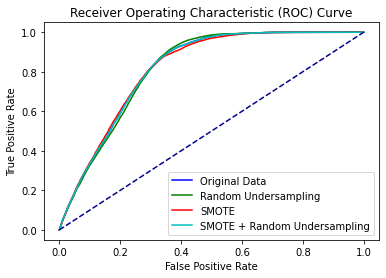

In [23]:
#STAMPA DELLE CURVE ROC
plot_roc(gnb, gnb_us, gnb_os, gnb_mix, X_test = X_test, y_test = y_test, labels=lab)

In generale i modelli Naive-Bayes generati con i vari dataset non si sono rivelati soddisfacenti, in particolare quello
addestrato con dataset sbilanciato ha prestazioni pessime, mentre gli altri si comportano comunque molto meglio di un
classificatore casuale. Il migliore risulta essere quello addestrato con dataset bilanciato tramite mix di SMOTE + Undersampling

### SVM

Di seguito si andranno a valutare le prestazioni di SVM, addestrati come al solito sui vari dataset
Utilizzando kernel lineare la SVM separa tramite un iperpiano le istanze in classi.


In [27]:
#SVM CON DATASET SBILANCIATO
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.869180

Sensitivity:   0.039535

Specificity:   0.985068



(0.8691803766191738, 0.03953471776207807, 0.9850677830940989)

In [25]:
#SVM CON UNDERSAMPLING CASUALE

clf = svm.SVC(kernel='linear')
clf.fit(X_train_under, y_train_under)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.740958

Sensitivity:   0.773710

Specificity:   0.736384



(0.7409584284502287, 0.7737101263112823, 0.7363835725677831)

In [19]:
#SVM CON SMOTE
clf = svm.SVC(kernel='linear')
clf.fit(X_train_over, y_train_over)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.686652

Sensitivity:   0.858060

Specificity:   0.662709



(0.6866521476738999, 0.8580603725112396, 0.6627093301435407)

In [20]:
#SVM CON SMOTE + UNDERSAMPLING
clf = svm.SVC(kernel='linear')
clf.fit(X_train_mix, y_train_mix)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.737609

Sensitivity:   0.783986

Specificity:   0.731130



(0.7376085644564562, 0.7839862984371655, 0.7311303827751197)

Una soluzione allo sbilanciamento alternativa alla alterazione del dataset è quella di applicare una funzione di peso
che permette di dare più importanza alle istanze di una classe rispetto a quelle dell'altra
In questo caso si applica la funzione di peso al metodo di classificazione SVM
In particolare i pesi (parametro `weights`) utilizzati sono 1 per la classe di maggioranza e 5 per la classe di
minoranza, per ottenere un peso simile tra le classi

In [22]:
#SVM CON COSTI
clf = svm.SVC(kernel='linear', class_weight= {0 : 1, 1 : 5})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.656984

Sensitivity:   0.933419

Specificity:   0.618371



(0.6569844226951099, 0.9334189681010491, 0.6183712121212122)

SVM restituisce risultati pessimi quando è addestrato con il dataset sbilanciato, praticamente classifica ogni istanza
come appartenente alla classe di minoranza; quando viene addestrato con il dataset sbilanciato al quale viene applicata
una funzione di costo oppure con il dataset bilanciato con SMOTE si notano prestazioni ottime in sensitivity a discapito
della specificity. Al solito il modello che ha prestazioni migliori è quello addestrato con il dataset bilanciato con
il metodo ibrido SMOTE + Undersampling



L'algoritmo XGBoost si basa sul metodo del gradient boosting che utilizza le derivate di secondo ordine, cioè il
gradiente, per trovare il miglior modello ad albero grazie ad una esaustiva valutazione di tutte le possibili
suddivisioni ad ogni passo dell'algoritmo.
I modelli generati saranno due, addestrati rispettivamente con il dataset ribilanciato con Undersampling casuale e
con il dataset originale al quale sono stati applicati dei pesi

In [ ]:
#XGBOOST su UNDERSAMPLED
from xgboost import XGBClassifier

XGB = XGBClassifier(tree_method= "gpu_hist", single_precision_histogram = True, eval_metric = 'logloss')
XGB = XGB.fit(X_train_under, y_train_under)
pred = XGB.predict(X_test)
confusionMatrix(pred, y_test, verbose=True)

In [10]:
XGB = XGBClassifier(tree_method= "gpu_hist", single_precision_histogram = True, scale_pos_weight=7, eval_metric = 'logloss')
XGB = XGB.fit(X_train, y_train)
pred = XGB.predict(X_test)
confusionMatrix(pred, y_test, verbose=True)


Accuracy:      0.712681

Sensitivity:   0.908656

Specificity:   0.685307



(0.7126813780798195, 0.9086562477699279, 0.6853070175438597)

Le prestazioni dei modelli XGBoost sono molto buone e risultano essere leggermente più bilanciate tra sensitivity e
specificity nel caso del dataset ribilanciato mentre l'altro modello si rivela molto migliore in sensitivity piuttosto
che in specificity

## CONCLUSIONI

In questa analisi si dovrebbe prediligere la specificity in quanto siamo interessati a classificare bene il maggior
numero di potenziali clienti. A tal proposito tra i modelli generati, l'albero di decisione risultato migliore è quello
addestrato con dataset bilanciato con Undersampling casuale mentre il Naive-Bayes restituisce risultati migliori quando
addestrato con dataset bilanciato con ibrido tra SMOTE e Undersampling casuale. Entrambi però non hanno prestazioni
soddisfacenti. L'SVM invece ha prestazioni molto migliori ma è penalizzato da lunghi tempi di esecuzioni che esso comporta.
Viste le prestazioni dei modelli elencati fino ad ora si può concludere che come tecnica di bilanciamento del dataset
di training lo SMOTE puro non è un metodo competitivo.
Il modello risultato sicuramente migliore è quello generato dall'XGBoost sul dataset bilanciato con
sottocampionamento casuale, sia per quanto riguarda le prestazioni che per quanto riguarda i tempi di esecuzione,
anche grazie alla possibilità di far eseguire i calcoli alla GPU piuttosto che alla CPU
